In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import pytorch_lightning as pl
import soundfile as sf
import matplotlib.pyplot as plt
import librosa as lb
import librosa.display
from scipy.fftpack import fft, dct

from argparse import Namespace
from tqdm.notebook import tqdm

print(torch.cuda.is_available())
device = 'cuda'
device = 'cpu'

True


(3528,)


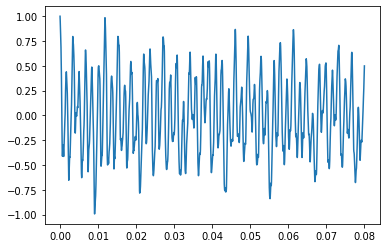

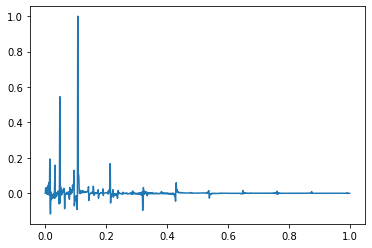

In [3]:
x, fs = sf.read('../data/piano.wav')
# to mono
x = np.mean(x, axis=-1)

dur = 0.08

x = x[2*fs:int((2+dur)*fs)]
x = x - np.mean(x)
x = x / np.max(np.abs(x))
t = np.arange(0,dur,1/fs)
print(x.shape)

plt.plot(t, x)
plt.show()


X = dct(x)[:len(x)//4]
X = X/np.max(np.abs(X))
f = np.linspace(0,1,len(X))
plt.plot(f, X)
plt.show()

s = torch.from_numpy(x).float()
t = torch.from_numpy(t).float()
S = torch.from_numpy(X).float()
f = torch.from_numpy(f).float()

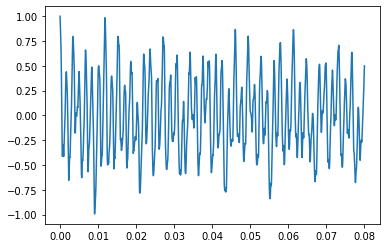

In [4]:
class CurrDataset(torch.utils.data.Dataset):

    def __init__(self, t, x):
        super(CurrDataset, self).__init__()

        self.x = x[:,None]
        self.t = t[:,None]
        assert x.shape == t.shape
        self.size = x.shape[0]

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        t = self.t[idx,:]
        x = self.x[idx,:]
        return t, x

dataset = CurrDataset(t, s)
invar, outvar = dataset[:]

plt.plot(invar, outvar)
plt.show()

In [ ]:
from recipes.audio.model import MFN

model = MFN(1, 256, 2, k)
model.load_state_dict(torch.load('../recipes/audio/model.ptc'))
print(model)

invar, outvar = dataset[:]

outvar_pred = model(invar, stage='train_time')[0]

plt.figure(figsize=(15,10))
plt.plot(invar, outvar, label='gt')
plt.plot(invar.detach(), outvar_pred[:,0].detach(), label='pred')

# invar = torch.linspace(0, 0.08, 100)[:,None]
# outvar_pred = model(invar, stage='train_time')[0]
# plt.plot(invar.detach(), outvar_pred[:,0].detach(), label='new times')
plt.legend()
plt.show()

In [ ]:
from recipes.audio.model import iMFN

model = iMFN()
model.load_state_dict(torch.load('../recipes/audio/model.ptc'))
print(model)

invar, outvar = dataset[:]

outvar_pred = model(invar, stage='train_time')[0]

plt.figure(figsize=(15,10))
plt.plot(invar, outvar, label='gt')
plt.plot(invar.detach(), outvar_pred[:,0].detach(), alpha=0.5, label='pred')

freqs = model.time[0].linear.weight.data
freqs = torch.sort(freqs, dim=0)[0]
outvar_pred = model(invar, ftest=freqs, stage='test')[0]

plt.plot(invar.detach(), outvar_pred[:,0].detach(), label='new freqs')
plt.legend()
plt.show()

In [ ]:
model = iMFN()
model.load_state_dict(torch.load('../recipes/audio/model.ptc'))
freqs = model.time[0].linear.weight.data
freqs = torch.sort(freqs, dim=0)[0]

idx1 = np.arange(freqs.shape[0])
freqs1 = freqs[idx1, :]
weights1 = model.fft(freqs1)

# freqs2 = torch.linspace(-2e3, 2e3, freqs.shape[0])[:,None]
base = 512
l = 510

idx2 = idx1[base-l:base+l]
idx2 = idx2[::2]
freqs2 = freqs1[idx2,:]

# freqs2 = torch.linspace(freqs2.min(), freqs2.max(), len(idx2))[:,None]

weights2 = model.fft(freqs2)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('sorted W_1 and query freqs')
plt.plot(idx1, freqs1.squeeze())
plt.plot(idx2, freqs2.squeeze())
plt.subplot(122)
plt.title('sorted W_2 and W_2= DNN(freqs)')
plt.plot(freqs1.squeeze(), weights1.squeeze().detach().numpy())
plt.plot(freqs2.squeeze(), weights2.squeeze().detach().numpy(), alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,10))
plt.plot(freqs1.squeeze(), weights1.squeeze().detach().numpy())
plt.plot(freqs2.squeeze(), weights2.squeeze().detach().numpy())
plt.xlim([freqs1[base-l-50,0], freqs1[base+l+50,0]])
plt.show()


plt.figure(figsize=(15,10))
plt.plot(invar, outvar, label='gt')
# plt.plot(invar.detach(), outvar_pred[:,0].detach(), label='pred')

outvar_pred = model(invar, ftest=freqs2, stage='test')[0]

plt.plot(invar.detach(), outvar_pred[:,0].detach(), alpha=1, label='new freqs')
plt.legend()
plt.show()

In [ ]:
from recipes.audio.model import iMFN

model = iMFN()
model.load_state_dict(torch.load('../recipes/audio/model.ptc'))
print(model)

f = model.freq1_flt.linear.weight.detach().numpy()


F = dct(f)
plt.plot(F)

In [ ]:
model = iMFN()
model.load_state_dict(torch.load('../recipes/audio/model.ptc'))
print(model)

invar, outvar = dataset[:]

outvar_pred = model(invar, stage='train_time')[0]

plt.figure(figsize=(15,10))
plt.plot(invar, outvar)
plt.plot(invar.detach(), outvar_pred[:,0].detach())

freqs = model.flt_t1.linear.weight.data
freqs = freqs[::1]
idx = torch.argsort(freqs, dim=0).squeeze()
freqs = freqs[idx,:]
freqs = freqs[512-512:512+512] # low pass
# freqs = torch.linspace(freqs.min(), freqs.max(), 1024)[:,None]
outvar_pred = model(invar, ftest=freqs, stage='test')[0]

plt.plot(invar.detach(), outvar_pred[:,0].detach())
plt.show()

In [ ]:
w = model.lin_t1.weight.data
f = model.flt_t1.linear.weight.data
c = model.lin_f1(model.flt_f1(f)).data

idx = torch.argsort(f, dim=0)
f = f.squeeze()[idx]
w = w.squeeze()[idx]
c = c.squeeze()[idx]

plt.plot(f)
plt.show()
plt.plot(f, c)
plt.show()
plt.plot(f, w)
plt.show()

In [ ]:
model = iMFN()
model.load_state_dict(torch.load('./model.ptc'))

w = model.lin_t1.weight.data
f_w = model.flt_t1.linear.weight.data

idx = torch.argsort(f_w, dim=0)
f_w = f_w.squeeze()[idx].squeeze()
f_w = f_w[512:600]
# f_w = torch.linspace(f_w.min(), f_w.max(), 1024)
plt.plot(f_w)
plt.show()

c = model.lin_f1(model.flt_f1(f_w[:,None]))
print(f_w.shape)
print(model.flt_f1(f_w[:,None]).data.shape)
print(model.lin_f1(model.flt_f1(f_w[:,None])).data.shape)
w = w.squeeze()[idx].squeeze()

plt.figure(figsize=(15,10))
plt.plot(w.squeeze().detach())
plt.plot(c.detach(), alpha=0.2)
plt.show()


model.lin_t1.weight.data = w[None,:]
model.flt_t1.linear.weight.data = f_w[:,None]
model.lin_f1.weight.data = c.T

invar, outvar = dataset[:]
stage = 'test'
outvar_pred = model(invar, stage)[0]

plt.figure(figsize=(15,10))
plt.plot(invar, outvar)
plt.plot(invar.detach(), outvar_pred[:,0].detach())
plt.show()

In [ ]:
S = lb.stft(signal[:,0].numpy())  # STFT of y
S_db = lb.amplitude_to_db(np.abs(S), ref=np.max)

plt.figure()
librosa.display.specshow(S_db)
plt.colorbar()

In [ ]:
signal = x_pred[:,0].detach().numpy()

S = lb.stft(signal)  # STFT of y
S_db = lb.amplitude_to_db(np.abs(S), ref=np.max)

plt.figure()
librosa.display.specshow(S_db)
plt.colorbar()

In [ ]:
print(model)
w1 = model.flt_t.linear.weight.data
print(w1.shape)
b1 = model.flt_t.linear.bias.data
print(b1.shape)
w2 = model.lin_t.weight.data
print(w2.shape)


In [ ]:
idx = torch.argsort(freqs, dim=0)
f = freqs[idx,0]
c = coeff[0,idx]

print(f)
print(c)

plt.plot(f, torch.abs(c))
plt.show()

S = lb.stft(signal)  # STFT of y

plt.plot(np.mean(np.abs(S), axis=1))

In [ ]:
# model = MFN(in_dim=1, hidden_dim=1024, out_dim=1, k=1, filter_fun='Fourier', data_max_freq=22e3)
# model.load_state_dict(torch.load('./model.ptc'))

f = model.flt.linear.weight.data
p = model.flt.linear.bias.data
c = model.lin.weight.data

print(f.shape)
print(p.shape)
print(c.shape)

idx = torch.argsort(f, dim=0).squeeze()
f = f[idx,:]
p = p[idx]
c = c[:,idx]


f_ = torch.zeros_like(f)
nfreq = 400
f1 = 512-nfreq
f2 = 512+nfreq
f_[f1:f2,:] = f[f1:f2,:]
f = f_

print(f)


c_ = torch.zeros_like(c)
nfreq = 400
f1 = 512-nfreq
f2 = 512+nfreq
c_[:,f1:f2] = c[:,f1:f2]
c = c_

model.flt.linear.weight.data = f
model.flt.linear.bias.data = p
model.lin.weight.data = c

x_pred = model(t[:,None], z)
print(x_pred.shape)

plt.figure(figsize=(15,10))
plt.plot(time, signal, alpha=0.5)
plt.plot(t.detach(), x_pred[:,0].detach())
plt.show()